In [1]:
import pandas as pd
import os
import json
import torch
import numpy as np
from steams.data.KVyQVx import KVyQVx
from steams.models.mads import dpnn3
from steams.tepe.steams import attention_steams
from steams.tepe.tepe import train, evaluation, prediction_prime, ensemble_prime
from steams.utils.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 2
    pin_memory = True
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 20
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 20
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

In [9]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [10]:
#model
model = dpnn3(input_k=2,input_v=1, hidden_size=32)

In [11]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# steams object
obj = attention_steams(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [12]:
# training
train(obj,train_dataset,valid_dataset,niter=200,n_iter_stop=20,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  1.002745  0.996665
  epoch     train    valid
0     1  0.932781  0.57131
  epoch     train     valid
0     2  0.334865  0.195339
  epoch     train     valid
0     3  0.243658  0.174303
  epoch     train     valid
0     4  0.233503  0.158148
  epoch    train     valid
0     5  0.22956  0.178851
  epoch     train     valid
0     6  0.221173  0.173151
  epoch     train    valid
0     7  0.212437  0.16847
  epoch     train     valid
0     8  0.216092  0.151433
  epoch     train     valid
0     9  0.212167  0.160942
  epoch     train     valid
0    10  0.206328  0.142986
  epoch     train     valid
0    11  0.209888  0.137289
  epoch     train     valid
0    12  0.206923  0.149756
  epoch     train     valid
0    13  0.203482  0.143714
  epoch     train     valid
0    14  0.203037  0.143955
  epoch     train     valid
0    15  0.213313  0.132838
  epoch     train     valid
0    16  0.200433  0.148308
  epoch     train     valid
0    17  0.199597  0.14088

In [27]:
obj.save_model(resdir,"1d-dpnn3")

## Evaluation

In [28]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [29]:
criterion = R2()
#criterion = torch.nn.MSELoss()
obj.init_criterion(criterion)

In [30]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

/home/jean-marie/dev/01-packages/steams_pkg/steams/utils/scale.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[:,:,i] = data[:,:,i]*std_data.iloc[0][i] + mean_data.iloc[0][i]


0.8619466149806976


In [31]:
criterion = RMSE()
obj.init_criterion(criterion)

In [32]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.1586277969107032


In [33]:
criterion = variance()
obj.init_criterion(criterion)

In [34]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.014800185428233817


## QQplot

In [35]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [36]:
results = prediction_prime(obj,eval_dataset)

/home/jean-marie/dev/01-packages/steams_pkg/steams/utils/scale.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[:,:,i] = data[:,:,i]*std_data.iloc[0][i] + mean_data.iloc[0][i]
/home/jean-marie/dev/01-packages/steams_pkg/steams/utils/scale.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[:,i] = data[:,i]*std_data.iloc[0][i] + mean_data.iloc[0][i]
/home/jean-marie/dev/01-packages/steams_pkg/steams/tepe/tepe.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining 

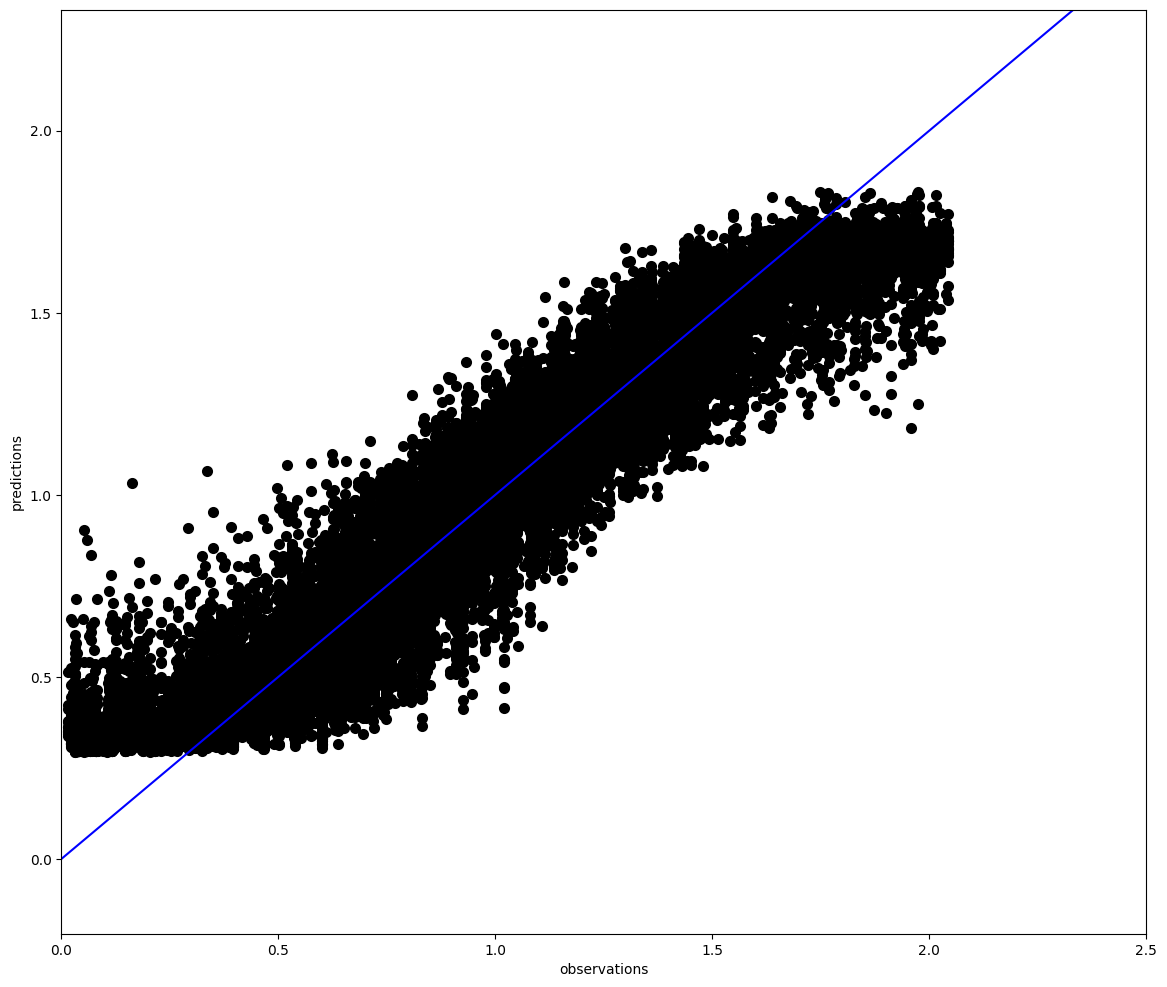

In [37]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1d-qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of Wq on a map

In [38]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400")
params['X']['nb_location'] = 6400

eval_dataset = KVyQVx(params)

In [39]:
eval_dataset.scale(True)
obj.model.eval()
with torch.no_grad():
    results = pd.DataFrame(columns=['x','y','Wqx','Wqy'])
    obs=[]
    pred=[]
    for i in range(len(eval_dataset)):
        
        KEY_Y,VALUE_Y,QUERY_X, VALUE_X = eval_dataset[i]
        QUERY_X = QUERY_X.to(obj.device)
    
        # input with dimension batch and on device
        QUERY_X = torch.reshape(QUERY_X,(1,QUERY_X.shape[0],QUERY_X.shape[1]))
        
        Wq = obj.model.W(QUERY_X.float() ).detach().cpu().numpy()
        
        QUERY_X_unscaled = eval_dataset.unscale(QUERY_X.detach(),"QUERY")

        # print(Wk.shape)
        # print(Wq.shape)
        # print(QUERY_X_unscaled.shape)
        
        tmp = np.concatenate((QUERY_X_unscaled, Wq),2)
        tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
        
        tmp_df = pd.DataFrame(tmp,columns=['x','y','Wqx','Wqy'])
        
        results = pd.concat([results,tmp_df],ignore_index=True,axis=0)
eval_dataset.scale(False)        

/home/jean-marie/dev/01-packages/steams_pkg/steams/utils/scale.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[:,:,i] = data[:,:,i]*std_data.iloc[0][i] + mean_data.iloc[0][i]
/tmp/ipykernel_13353/2950225290.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)
/home/jean-marie/dev/01-packages/steams_pkg/steams/utils/scale.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

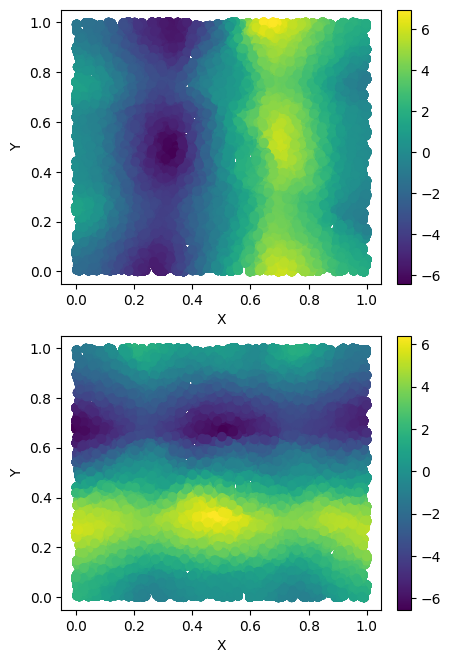

In [40]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(4, 4, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.scatter(x=results["x"], y=results["y"], c=results["Wqx"], vmax=np.max(results["Wqx"]))
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[1,0])
c1 = ax1.scatter(x=results["x"], y=results["y"], c=results["Wqy"], vmax=np.max(results["Wqy"]))
ax1.set(ylabel='Y',xlabel='X')

fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)

fig_filename = os.path.join(parent_dir,'fig','1d-illustration_W.png')
plt.savefig(fig_filename, dpi = 300)
